#Intelligent Spam Detection Using Machine Learning
Project Overview:
This project uses machine learning to detect spam emails. We will preprocess the data, extract features using TF-IDF, train a Naive Bayes classifier, evaluate it, and finally create a GUI for user input.


In [118]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle

In [119]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [120]:
file_path = "/mnt/data/spam mail.csv"
df = pd.read_csv('/content/spam_mail.csv')

In [121]:
print("Dataset Columns:", df.columns)

Dataset Columns: Index(['Category', 'Masseges'], dtype='object')


In [122]:
if 'Masseges' in df.columns:
    df.rename(columns={'Masseges': 'Messages'}, inplace=True)

In [123]:
if 'Messages' not in df.columns or 'Category' not in df.columns:
    raise ValueError("Error: Expected columns 'Messages' and 'Category' not found in the dataset.")

In [124]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [125]:
try:
    stop_words = set(stopwords.words('english'))
except:
    stop_words = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
                      "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself",
                      "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which",
                      "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be",
                      "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
                      "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by",
                      "for", "with", "about", "against", "between", "into", "through", "during", "before",
                      "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over",
                      "under", "again", "further", "then", "once", "here", "there", "when", "where", "why",
                      "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such",
                      "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can",
                      "will", "just", "don", "should", "now"])
    print("Warning: NLTK stopwords not found. Using custom stopwords.")

lemmatizer = WordNetLemmatizer()

In [126]:
def get_wordnet_pos(word):
    try:
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    except:
        return wordnet.NOUN

In [127]:
def preprocess_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    return ' '.join(tokens)

In [128]:
df['Cleaned_Messages'] = df['Messages'].apply(preprocess_text)

In [129]:
print("Category Unique Values:", df['Category'].unique())

Category Unique Values: ['ham' 'spam']


In [130]:
if 'spam' in df['Category'].values and 'ham' in df['Category'].values:
    df['Category'] = df['Category'].map({'spam': 1, 'ham': 0})
else:
    raise ValueError("Error: Unexpected values found in 'Category' column. Expected 'spam' and 'ham'.")

In [131]:
X = df['Cleaned_Messages']
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [132]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [133]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy')

In [134]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_tfidf, y_train)


MultinomialNB(alpha=0.1)

In [135]:
y_pred = best_model.predict(X_test_tfidf)

In [136]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [137]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.97
Precision: 0.96
Recall: 0.84
F1 Score: 0.89


In [138]:
with open('spam_classifier.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

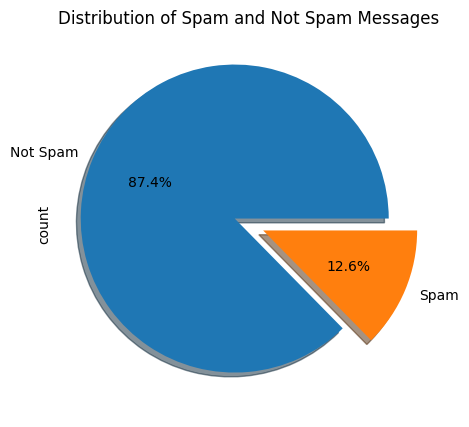

In [139]:
plt.figure(figsize=(5, 5))
df['Category'].value_counts().plot(kind='pie', labels=['Not Spam', 'Spam'], autopct='%1.1f%%', explode=[0.1, 0.1], shadow=True)
plt.title('Distribution of Spam and Not Spam Messages')
plt.show()


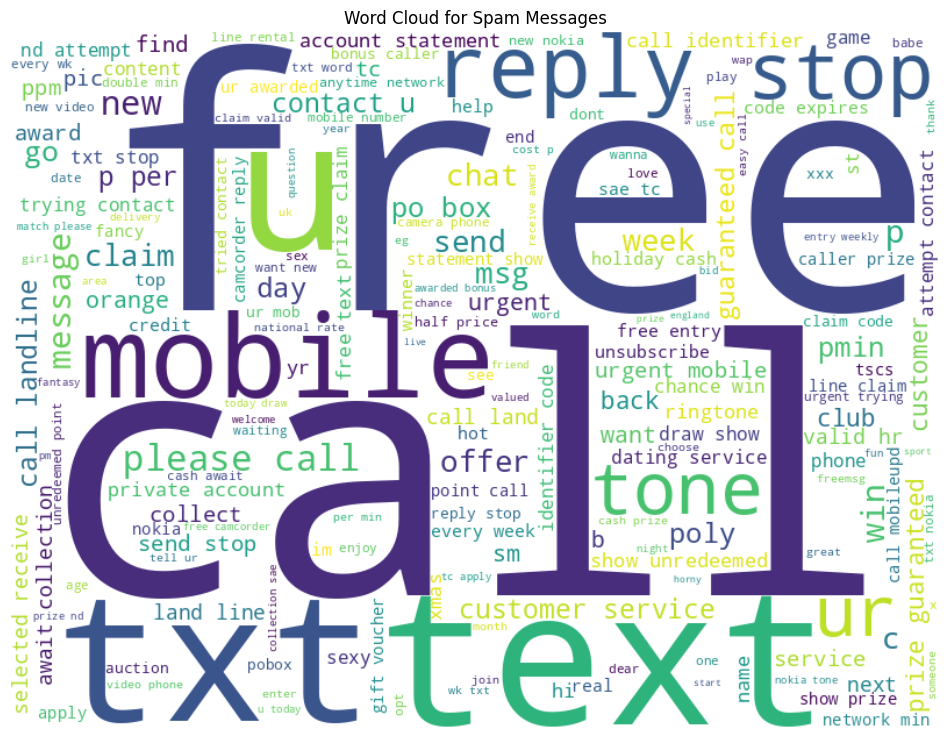

In [140]:
spam_text = ' '.join(df[df['Category'] == 1]['Cleaned_Messages'])
spam_wc = WordCloud(width=800, height=600, background_color='white').generate(spam_text)

plt.figure(figsize=(12, 10))
plt.imshow(spam_wc, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')
plt.show()
